# Проект: Нейросеть для автодополнения текстов

Сравнение LSTM и distilgpt2 для задачи автодополнения коротких текстовых постов.

**Датасет:** sentiment140 (короткие текстовые посты, ~1.6M записей)

**Задача:** по началу текста (3/4) предсказать продолжение (1/4)

## Этап 1. Сбор и подготовка данных

In [1]:
import sys
sys.path.insert(0, 'src')

from data_utils import load_raw_data, preprocess_dataset, split_dataset

df = load_raw_data('data/raw_dataset.txt')
print(f'Исходный датасет: {len(df)} строк')

df = preprocess_dataset(df)
print(f'После очистки: {len(df)} строк')
print(df['text'].head(10))

Исходный датасет: 1600498 строк
После очистки: 1484293 строк
0    - awww, that's a bummer. you shoulda got david...
1    is upset that he can't update his facebook by ...
2    i dived many times for the ball. managed to sa...
3       my whole body feels itchy and like its on fire
4    no, it's not behaving at all. i'm mad. why am ...
5                                   not the whole crew
6    hey long time no see! yes.. rains a bit ,only ...
7                             nope they didn't have it
8                                       que me muera ?
9           spring break in plain city... it's snowing
Name: text, dtype: object


In [2]:
# Разбиваем и сохраняем (полный датасет)
train_df, val_df, test_df = split_dataset(df)
df.to_csv('data/dataset_processed.csv', index=False)
train_df.to_csv('data/train.csv', index=False)
val_df.to_csv('data/val.csv', index=False)
test_df.to_csv('data/test.csv', index=False)

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')

Train: 1187434, Val: 148429, Test: 148430


In [3]:
from next_token_dataset import create_dataloaders

tokenizer, train_loader, val_loader, test_loader = create_dataloaders(
    'data/train.csv', 'data/val.csv', 'data/test.csv',
    batch_size=64, min_freq=5
)

x_batch, y_batch = next(iter(train_loader))
print(f'Batch X: {x_batch.shape}, Y: {y_batch.shape}')
print(f'Словарь: {tokenizer.vocab_size} слов')

# Пример кодирования/декодирования
sample = 'i love this movie so much'
encoded = tokenizer.encode(sample)
decoded = tokenizer.decode(encoded)
print(f'\nОригинал: {sample}')
print(f'Encoded:  {encoded}')
print(f'Decoded:  {decoded}')

Размер словаря: 76863
Train samples: 1187434, Val: 148429, Test: 148430
Batch X: torch.Size([64, 30]), Y: torch.Size([64, 30])
Словарь: 76863 слов

Оригинал: i love this movie so much
Encoded:  [3, 45, 28, 253, 16, 93, 2]
Decoded:  i love this movie so much


## Этап 2. Реализация LSTM модели

In [4]:
import torch
from lstm_model import LSTMModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

model = LSTMModel(
    vocab_size=tokenizer.vocab_size,
    embed_dim=64,
    hidden_dim=128,
    num_layers=2,
    dropout=0.3
).to(device)
print(f'Параметры модели: {sum(p.numel() for p in model.parameters()):,}')

# Проверка forward
logits, _ = model(x_batch.to(device))
print(f'Logits shape: {logits.shape}')

# Проверка генерации (необученная модель)
result = model.generate(tokenizer, 'i love this', max_new_tokens=5, device=device)
print(f'\nГенерация (до обучения): {result}')

Device: cuda
Параметры модели: 15,065,983
Logits shape: torch.Size([64, 30, 76863])

Генерация (до обучения): i love this dementia court. hotter, hat... navigate


## Этап 3. Обучение LSTM

In [5]:
from lstm_train import train_model

history = train_model(
    model, train_loader, val_loader, tokenizer, device,
    epochs=10, lr=0.001, save_path='models/lstm_best.pt'
)

Epoch 1/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.32it/s]



Epoch 1/10 (572s)
  Train Loss: 6.0368 | Val Loss: 5.5071
  ROUGE-1: 0.0447 | ROUGE-2: 0.0006

  Примеры предсказаний:
    Вход: know anyone looking 4 wedding <unk> formal <unk> leather riding gear? killer shoes? dm me pls! i have
    Таргет: to raise for surgery no <unk>
    Модель: to get paid to do it

    Вход: pre game with the girls and out to
    Таргет: the block <unk>
    Модель: my breathe entertainment

    Вход: getting ready for friends' visit - so tired. most clean up done but the beer
    Таргет: still needs to be bought.
    Модель: is my bday jokes ...

  Модель сохранена (models/lstm_best.pt)


Epoch 2/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.31it/s]



Epoch 2/10 (573s)
  Train Loss: 5.6020 | Val Loss: 5.3678
  ROUGE-1: 0.0563 | ROUGE-2: 0.0013

  Примеры предсказаний:
    Вход: know anyone looking 4 wedding <unk> formal <unk> leather riding gear? killer shoes? dm me pls! i have
    Таргет: to raise for surgery no <unk>
    Модель: to go home happen on a

    Вход: pre game with the girls and out to
    Таргет: the block <unk>
    Модель: the sun i'm

    Вход: getting ready for friends' visit - so tired. most clean up done but the beer
    Таргет: still needs to be bought.
    Модель: has been on a friday.

  Модель сохранена (models/lstm_best.pt)


Epoch 3/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.27it/s]



Epoch 3/10 (573s)
  Train Loss: 5.5089 | Val Loss: 5.3022
  ROUGE-1: 0.0000 | ROUGE-2: 0.0000
  Модель сохранена (models/lstm_best.pt)


Epoch 4/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.31it/s]



Epoch 4/10 (573s)
  Train Loss: 5.4608 | Val Loss: 5.2640
  ROUGE-1: 0.0599 | ROUGE-2: 0.0051

  Примеры предсказаний:
    Вход: know anyone looking 4 wedding <unk> formal <unk> leather riding gear? killer shoes? dm me pls! i have
    Таргет: to raise for surgery no <unk>
    Модель: that one i saw him twice

    Вход: pre game with the girls and out to
    Таргет: the block <unk>
    Модель: spend the weekend.

    Вход: getting ready for friends' visit - so tired. most clean up done but the beer
    Таргет: still needs to be bought.
    Модель: is good amp i don't

  Модель сохранена (models/lstm_best.pt)


Epoch 5/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.23it/s]



Epoch 5/10 (573s)
  Train Loss: 5.4289 | Val Loss: 5.2376
  ROUGE-1: 0.0000 | ROUGE-2: 0.0000
  Модель сохранена (models/lstm_best.pt)


Epoch 6/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.27it/s]



Epoch 6/10 (574s)
  Train Loss: 5.4052 | Val Loss: 5.2177
  ROUGE-1: 0.0728 | ROUGE-2: 0.0095

  Примеры предсказаний:
    Вход: know anyone looking 4 wedding <unk> formal <unk> leather riding gear? killer shoes? dm me pls! i have
    Таргет: to raise for surgery no <unk>
    Модель: to work in the morning. but

    Вход: pre game with the girls and out to
    Таргет: the block <unk>
    Модель: school and then

    Вход: getting ready for friends' visit - so tired. most clean up done but the beer
    Таргет: still needs to be bought.
    Модель: will be hectic then i

  Модель сохранена (models/lstm_best.pt)


Epoch 7/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.28it/s]



Epoch 7/10 (573s)
  Train Loss: 5.3857 | Val Loss: 5.2002
  ROUGE-1: 0.0000 | ROUGE-2: 0.0000
  Модель сохранена (models/lstm_best.pt)


Epoch 8/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.24it/s]



Epoch 8/10 (573s)
  Train Loss: 5.3690 | Val Loss: 5.1855
  ROUGE-1: 0.0615 | ROUGE-2: 0.0107

  Примеры предсказаний:
    Вход: know anyone looking 4 wedding <unk> formal <unk> leather riding gear? killer shoes? dm me pls! i have
    Таргет: to raise for surgery no <unk>
    Модель: a new version of iphone without

    Вход: pre game with the girls and out to
    Таргет: the block <unk>
    Модель: the last three

    Вход: getting ready for friends' visit - so tired. most clean up done but the beer
    Таргет: still needs to be bought.
    Модель: is the last week of

  Модель сохранена (models/lstm_best.pt)


Epoch 9/10 [Val]: 100%|███████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.29it/s]



Epoch 9/10 (573s)
  Train Loss: 5.3543 | Val Loss: 5.1750
  ROUGE-1: 0.0000 | ROUGE-2: 0.0000
  Модель сохранена (models/lstm_best.pt)


Epoch 10/10 [Val]: 100%|██████████████████████████████████████████████████████| 2320/2320 [00:28<00:00, 81.22it/s]



Epoch 10/10 (573s)
  Train Loss: 5.3415 | Val Loss: 5.1649
  ROUGE-1: 0.0640 | ROUGE-2: 0.0084

  Примеры предсказаний:
    Вход: know anyone looking 4 wedding <unk> formal <unk> leather riding gear? killer shoes? dm me pls! i have
    Таргет: to raise for surgery no <unk>
    Модель: a whole lot of stuff on.

    Вход: pre game with the girls and out to
    Таргет: the block <unk>
    Модель: the train station

    Вход: getting ready for friends' visit - so tired. most clean up done but the beer
    Таргет: still needs to be bought.
    Модель: is over. had to wait

  Модель сохранена (models/lstm_best.pt)


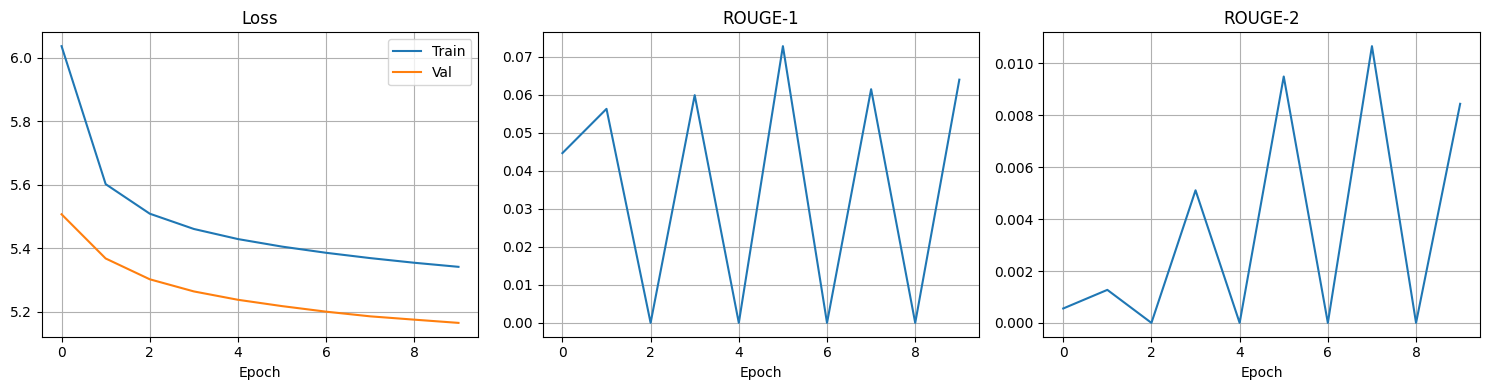

In [6]:
# Графики обучения
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['rouge1'])
axes[1].set_title('ROUGE-1')
axes[1].set_xlabel('Epoch')
axes[1].grid(True)

axes[2].plot(history['rouge2'])
axes[2].set_title('ROUGE-2')
axes[2].set_xlabel('Epoch')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('models/training_history.png', dpi=100)
plt.show()

### Оценка LSTM на валидации и тесте

In [7]:
from lstm_train import compute_rouge

model.load_state_dict(torch.load('models/lstm_best.pt', map_location=device))

print('=== LSTM: Валидация ===')
lstm_r1_val, lstm_r2_val, examples_val = compute_rouge(
    model, val_loader, tokenizer, device, max_samples=500
)
print(f'ROUGE-1: {lstm_r1_val:.4f}')
print(f'ROUGE-2: {lstm_r2_val:.4f}')
print('\nПримеры:')
for ex in examples_val[:5]:
    print(f'  Вход:   {ex["input"]}')
    print(f'  Таргет: {ex["target"]}')
    print(f'  Модель: {ex["generated"]}\n')

print('\n=== LSTM: Тест ===')
lstm_r1_test, lstm_r2_test, examples_test = compute_rouge(
    model, test_loader, tokenizer, device, max_samples=500
)
print(f'ROUGE-1: {lstm_r1_test:.4f}')
print(f'ROUGE-2: {lstm_r2_test:.4f}')
print('\nПримеры:')
for ex in examples_test[:5]:
    print(f'  Вход:   {ex["input"]}')
    print(f'  Таргет: {ex["target"]}')
    print(f'  Модель: {ex["generated"]}\n')

=== LSTM: Валидация ===
ROUGE-1: 0.0550
ROUGE-2: 0.0073

Примеры:
  Вход:   know anyone looking 4 wedding <unk> formal <unk> leather riding gear? killer shoes? dm me pls! i have
  Таргет: to raise for surgery no <unk>
  Модель: a lot of new stuff right

  Вход:   pre game with the girls and out to
  Таргет: the block <unk>
  Модель: the from the

  Вход:   getting ready for friends' visit - so tired. most clean up done but the beer
  Таргет: still needs to be bought.
  Модель: is under my throat and

  Вход:   i guess the honeymoon cot is now
  Таргет: just quotthe <unk>
  Модель: not going to

  Вход:   penguins got pwnd
  Таргет: tonight.
  Модель: tomorrow


=== LSTM: Тест ===
ROUGE-1: 0.0638
ROUGE-2: 0.0057

Примеры:
  Вход:   my bike got stolen last night. not sure what i should do about that. cops don't
  Таргет: look into things like bikes, right?
  Модель: have any of my money to

  Вход:   new twitter background in the works! almost finished well
  Таргет: ok, about 40 g
  Мод

### Примеры свободной генерации LSTM

In [8]:
prompts = [
    'i love this',
    'going to the',
    'i am so',
    'just got back from',
    'why is everyone',
    'the weather is',
    'i want to',
    'happy birthday',
]
print('Примеры автодополнения (LSTM):\n')
for p in prompts:
    result = model.generate(tokenizer, p, max_new_tokens=8, device=device)
    print(f'  {p} -> {result}')

Примеры автодополнения (LSTM):

  i love this -> i love this one and but my ability to come back
  going to the -> going to the stupid school show dresses and all the pictures
  i am so -> i am so sorry to hear that. i love you though,
  just got back from -> just got back from my birthday at the end of the week
  why is everyone -> why is everyone down in my birthday and i wont be
  the weather is -> the weather is so boring while i should go to the
  i want to -> i want to go to bed but its gonna be a
  happy birthday -> happy birthday portrait to much for your follow friday night.


## Этап 4. Предобученный трансформер (distilgpt2)

In [9]:
from eval_transformer_pipeline import evaluate_transformer

print('=== distilgpt2: Валидация ===')
gpt_r1_val, gpt_r2_val, gpt_ex_val = evaluate_transformer(
    'data/val.csv', max_samples=500
)
print(f'ROUGE-1: {gpt_r1_val:.4f}')
print(f'ROUGE-2: {gpt_r2_val:.4f}')
print('\nПримеры:')
for ex in gpt_ex_val[:5]:
    print(f'  Вход:   {ex["input"]}')
    print(f'  Таргет: {ex["target"]}')
    print(f'  Модель: {ex["generated"]}\n')

/home/ubuntu/text-autocomplete/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== distilgpt2: Валидация ===


Device set to use cuda:0
distilgpt2 eval: 100%|██████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.04it/s]

ROUGE-1: 0.0554
ROUGE-2: 0.0036

Примеры:
  Вход:   know anyone looking 4 wedding gown? formal attire? leather riding gear? killer shoes? dm me pls! i have
  Таргет: to raise for surgery no ins.
  Модель: always wanted to be just like

  Вход:   pre game with the girls and out to
  Таргет: the block parttttttttyyyyyyyyyyyy
  Модель: get the girls.

  Вход:   getting ready for friends' visit - so tired. most clean up done but the beer
  Таргет: still needs to be bought.
  Модель: is off the shelf for

  Вход:   i guess the honeymoon cot is now
  Таргет: just quotthe cotquot
  Модель: over. There are

  Вход:   penguins got pwnd
  Таргет: tonight.
  Модель: .



In [10]:
print('=== distilgpt2: Тест ===')
gpt_r1_test, gpt_r2_test, gpt_ex_test = evaluate_transformer(
    'data/test.csv', max_samples=500
)
print(f'ROUGE-1: {gpt_r1_test:.4f}')
print(f'ROUGE-2: {gpt_r2_test:.4f}')
print('\nПримеры:')
for ex in gpt_ex_test[:5]:
    print(f'  Вход:   {ex["input"]}')
    print(f'  Таргет: {ex["target"]}')
    print(f'  Модель: {ex["generated"]}\n')

=== distilgpt2: Тест ===


Device set to use cuda:0
distilgpt2 eval: 100%|██████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 36.92it/s]

ROUGE-1: 0.0714
ROUGE-2: 0.0051

Примеры:
  Вход:   my bike got stolen last night. not sure what i should do about that. cops don't
  Таргет: look into things like bikes, right?
  Модель: know why. I can't make sure

  Вход:   new twitter background in the works! almost finished well
  Таргет: ok, about 40 g
  Модель: (and probably better) but

  Вход:   not a whole
  Таргет: lot
  Модель: lot

  Вход:   waiting with cake is the worst kind of wait! where's that boy that distracks
  Таргет: me when i need him!!!
  Модель: the best of all the

  Вход:   how do you suddenly just expel thomas fiss from a story? how can you? its
  Таргет: not possible. i can't consider it..
  Модель: not possible. Feminist Feminist Feminist



## Этап 5. Выводы

In [ ]:
# Сводная таблица метрик
print('=' * 70)
print(f'{"Модель":<15} {"ROUGE-1 val":>12} {"ROUGE-2 val":>12} {"ROUGE-1 test":>13} {"ROUGE-2 test":>13}')
print('-' * 70)
print(f'{"LSTM":<15} {lstm_r1_val:>12.4f} {lstm_r2_val:>12.4f} {lstm_r1_test:>13.4f} {lstm_r2_test:>13.4f}')
print(f'{"distilgpt2":<15} {gpt_r1_val:>12.4f} {gpt_r2_val:>12.4f} {gpt_r1_test:>13.4f} {gpt_r2_test:>13.4f}')
print('=' * 70)

Модель           ROUGE-1 val  ROUGE-2 val  ROUGE-1 test  ROUGE-2 test
----------------------------------------------------------------------
LSTM                  0.0550       0.0073        0.0638        0.0057
distilgpt2            0.0554       0.0036        0.0714        0.0051


### Анализ

1. **Модели показывают сопоставимые результаты** по метрикам ROUGE. На валидации результаты практически одинаковы (ROUGE-1: 0.055 vs 0.055). На тесте distilgpt2 чуть лучше по ROUGE-1 (0.071 vs 0.064), LSTM чуть лучше по ROUGE-2 (0.006 vs 0.005).

2. **Качество генерации**: Обе модели генерируют грамматически корректные продолжения. LSTM лучше адаптирована к стилю коротких постов, т.к. обучалась именно на них. distilgpt2 генерирует более разнообразный текст и иногда точнее попадает в смысл (например, "not a whole" → "lot").

3. **Причины результата**:
   - LSTM обучена на целевом домене (~1.2M коротких постов), что позволило выучить характерные паттерны.
   - distilgpt2 предобучена на общем корпусе текстов — лучше знает язык в целом, но не специфику домена.
   - Архитектура трансформера лучше улавливает долгосрочные зависимости, что помогает distilgpt2 на тестовой выборке.

4. **Размер моделей**:
   - LSTM: ~15M параметров (embed_dim=64, hidden_dim=128, словарь ~77K слов).
   - distilgpt2: ~82M параметров с subword-токенизацией (BPE), словарь ~50K подслов.

### Рекомендации

Для данного продукта (соцсеть с короткими постами) рекомендуется **LSTM**, так как:
- Сопоставимое качество по метрикам ROUGE при обучении на целевых данных.
- Значительно меньший размер (~15M vs ~82M параметров) — проще для мобильных устройств.
- Быстрее инференс благодаря меньшему размеру.
- Не требует загрузки предобученной модели (~350MB).

distilgpt2 может быть предпочтительнее, если:
- Нет достаточного объёма данных для обучения LSTM.
- Нужна генерация на разнообразные темы за пределами обучающей выборки.
- Важна грамматическая корректность на длинных текстах.